# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Необходимо построить модель с максимально большим значением *accuracy* и довести долю правильных ответов по крайней мере до 0.75. 

## Откроем и изучим файл

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#для разделения выборки
from sklearn.model_selection import train_test_split
#для работы с деревом решений
from sklearn.tree import DecisionTreeClassifier
#для расчета доли правильных ответов
from sklearn.metrics import accuracy_score
#для работы с Логистической регресией
from sklearn.linear_model import LogisticRegression
#для работы со случайным лесом
from sklearn.ensemble import RandomForestClassifier
#построения модели для проверки на адекватность
from sklearn.dummy import DummyClassifier
#для работы с параметрами классификаторов
from sklearn.model_selection import GridSearchCV
#для корректного отображения через display
from IPython.display import display

#уменьшить запись чисел с после плавающей точки в таблицах
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Создадим словарь с основными названиями графиков

In [23]:
dict_name = {
    'distribution_main_features' : 'Распределение данных с учетом целевого признака',
    'accuracy_depth_tree' : 'Качество модели в зависимости от глубины дерева решений',
    'accuracy_n_estimators' : 'Качество модели в зависимости от числа деревьев решений',
    'accuracy_solver' : 'Качество модели в зависимости от гиперпараметра solver'
}

Загрузим данные датасета и посмотрим первичную информацию

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.000,311.900,83.000,19915.420,0
1,85.000,516.750,56.000,22696.960,0
2,77.000,467.660,86.000,21060.450,0
3,106.000,745.530,81.000,8437.390,1
4,66.000,418.740,1.000,14502.750,0


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

Датасет содержит 3214 значений, пять колонок:  
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  

Пустых значений нет, наименование столбцов соотвествуют стандартам snake_case, типы данных соотвествуют значениями.

Рассмотрим распределение данных в датасете с учетом целевого признака.

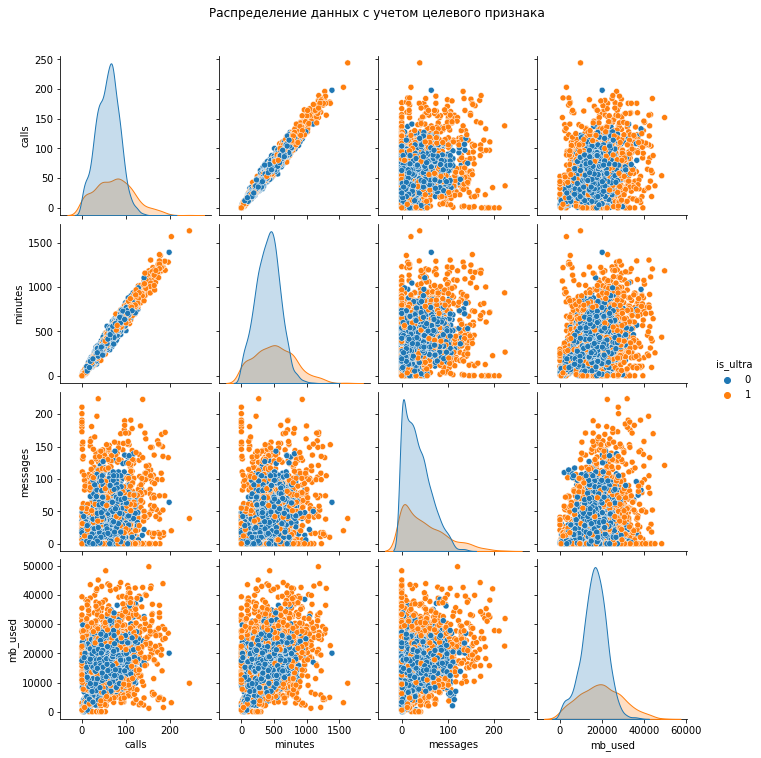

In [24]:
#выводим графики 
sns.pairplot(df, hue='is_ultra')
plt.suptitle(dict_name.get('distribution_main_features'), y=1.05) 
plt.show()

Рассмотрим основные статистические данные в основных признаках:

In [6]:
display(df.filter(df.columns[:-1]).describe())

,calls,minutes,messages,mb_used
count,3214.000,3214.000,3214.000,3214.000
mean,63.039,438.209,38.281,17207.674
std,33.236,234.570,36.148,7570.968
min,0.000,0.000,0.000,0.000
25%,40.000,274.575,9.000,12491.903
50%,62.000,430.600,30.000,16943.235
75%,82.000,571.927,57.000,21424.700
max,244.000,1632.060,224.000,49745.730


Проверим количество значений по 2 тарифам целевого признака:

In [7]:
print('Количество пользователей тарифа Ультра -', df.query('is_ultra == 1').shape[0])
print('Количество пользователей тарифа Смарт -', df.query('is_ultra == 0').shape[0])

Количество пользователей тарифа Ультра - 985
Количество пользователей тарифа Смарт - 2229


Доля пользователей Смарт - 69,35%,  
Доля пользователей Ультра - 30,64%,  
В последний месяц пользователи больше переходили на тариф Смарт.  

## Разделение данных на выборки

Для начала поделим выборку на целевой и прочие признаки

In [8]:
features = df.filter(df.columns[:-1])
target = df.is_ultra

Разделим выборку на 3 части `обучающую - 60%, валидационную - 20% и тестовую 20%`  

In [9]:
#делим выборку на обучающую и тестовую
features_train_all, features_test, target_train_all, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345
)
#делим обучающую выборку на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_all, target_train_all, test_size=0.25, random_state=12345
)

Посмотрим как распределились данные между выборками

In [10]:
display(pd.DataFrame(
    {'sample_type':['test_sample', 'train_sample', 'validation_sample'],
     'smart':[target_test[target_test == 0].shape[0], 
              target_train[target_train == 0].shape[0], 
              target_valid[target_valid == 0].shape[0]],
     'ultra':[target_test[target_test == 1].shape[0], 
              target_train[target_train == 1].shape[0], 
              target_valid[target_valid == 1].shape[0]],
     'total': [features_test.shape[0],
               features_train.shape[0],
               features_valid.shape[0]]
    }))

,sample_type,smart,ultra,total
0,test_sample,447,196,643
1,train_sample,1339,589,1928
2,validation_sample,443,200,643


Распределение произошло равномерно в соотвествии с задаными требованиями

## Исследование модели

В целях исследования моделей будем использовать алгоритмы классификации `Дерево решений, Случайный лес и Логистическую регрессию`.

Для начала обучим модель по самому простому алгоритму классификации `Дерева решений`, с разной глубиной дерева решений.

In [11]:
#функция для построения lineplot
def lineplot_helper(x:pd.Series, y:pd.Series, name_title: str)->None:
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=x, y=y)
    plt.title(name_title)
    plt.grid(visible=True)
    plt.show()

In [12]:
%%time
data = []
best_model = None
best_result = 0
#цикл для проверки доли правильных ответов при разной губине дерева решений  
for depth in range(1, 11):
    model_t = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_t.fit(features_train, target_train)
    predictions = model_t.predict(features_valid)
    res = accuracy_score(target_valid, predictions)
    data.append([depth, res])
    if res > best_result:
        best_model = model_t
        best_result = res

CPU times: user 76.8 ms, sys: 3.64 ms, total: 80.4 ms
Wall time: 79.4 ms


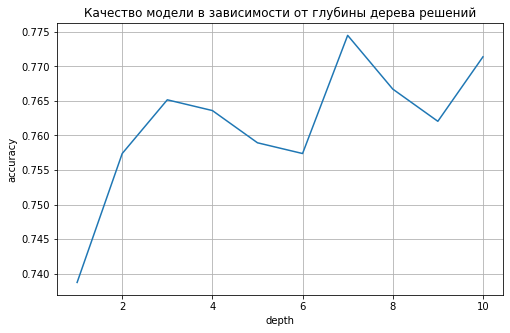

Лучший показатель дерева решений: 0.774, при глубине дерева - 7
Показатель дерева решений на обучающих данных 0.891


In [13]:
df_tree = pd.DataFrame(data, columns=['depth', 'accuracy'])
#строим график
lineplot_helper(x=df_tree['depth'], y=df_tree['accuracy'], name_title=dict_name.get('accuracy_depth_tree'))
print(f'Лучший показатель дерева решений: {round(best_result, 3)}, при глубине дерева -',
      int(df_tree.query("accuracy == accuracy.max()")["depth"])
     )
train_predictions = model_t.predict(features_train)
print(f'Показатель дерева решений на обучающих данных {round( accuracy_score(target_train, train_predictions), 3)}')

С увеличением глубины дерева решений увеличивается доля правильных ответов модели на валидационной выборке с небольшими спадами при глубине `4 и 5`, до максимального значения при глубине. **0,774** доли правильных ответов, на первый взгляд хороший показатель для модели, так же стоит обратить внимание что показатели на обучающей выборке `0.891` выше, чем на валидационной, что говорит нам о переобучении данной модели.

Обучим модель по алгоритму классификации `Логистической регресии`, она быстрее по скорости и с более низкой вероятностью переобучить модель и хорошо подходит для бинарной классификации. Проверим улучшение модели изменениями гиперпараметра `solver`

In [14]:
%%time
list_solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
data_lr = []
best_model_lr = None
best_result_lr = 0
#цикл для доли правильных ответов алгоритма линейной регрессии
for solver in list_solver:
    model_lr = LogisticRegression(random_state=12345, solver=solver, max_iter=1000)
    model_lr.fit(features_train, target_train)
    model_lr.predict(features_valid)
    result = model_lr.score(features_valid, target_valid)
    data_lr.append([solver, result])
    if result > best_result_lr:
        best_model_lr = model_lr
        best_result_lr = result     

CPU times: user 537 ms, sys: 0 ns, total: 537 ms
Wall time: 544 ms


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


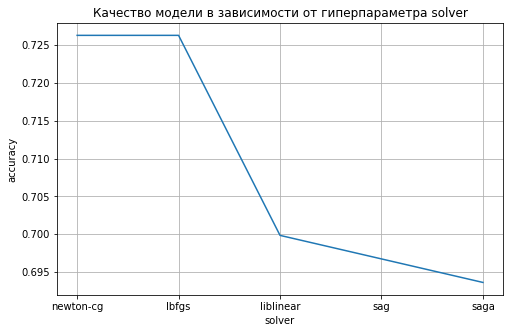

Лучший показатель Линейной регрессии: 0.726, при solver: lbfgs


In [15]:
df_lr = pd.DataFrame(data_lr, columns=['solver', 'accuracy'])
lineplot_helper(x=df_lr['solver'], 
                y=df_lr['accuracy'], 
                name_title=dict_name.get('accuracy_solver'))
print(f'Лучший показатель Линейной регрессии: {round(best_result_lr, 3)},', 
      f'при solver: {(df_lr.query("accuracy == accuracy.max()")["solver"][1])}')

Лучший показатель `Линейной регрессии 0.726` хуже показателя `Дерева решений 0.774`, но при переобученности модели Дерева решений. Решатели `newton-cg` и `lbfgs` показали однинаковые результаты доли правильных ответов, на много лучшие, чем остальные решатели.

Обучим модель по алгоритму классификации `Случайный лес`

In [16]:
%%time
data_f = []
best_model_f = None
best_result_f = 0
#Проверяем работу модели на алгоритме Случайный лес от 1 до 30 деревьев
for est in range(1, 46):
    f_model = RandomForestClassifier(random_state=12345, n_estimators=est)
    f_model.fit(features_train, target_train)
    res = f_model.score(features_valid, target_valid)
    data_f.append([est, res])
    if res > best_result_f:
        best_model_f = f_model
        best_result_f = res

CPU times: user 4.76 s, sys: 26.5 ms, total: 4.79 s
Wall time: 4.8 s


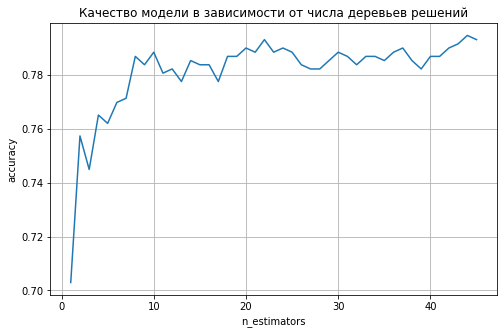

Лучший показатель алгоритма Случайный лес: 0.795, при 44 деревьев решений


In [17]:
df_random_forest = pd.DataFrame(data_f, columns = ['n_estimators', 'accuracy'])

lineplot_helper(x=df_random_forest['n_estimators'], 
                y=df_random_forest['accuracy'], 
                name_title=dict_name.get('accuracy_n_estimators'))

print(f'Лучший показатель алгоритма Случайный лес: {round(best_result_f, 3)},', 
      f'при {int(df_random_forest.query("accuracy == accuracy.max()")["n_estimators"])} деревьев решений')

При количестве деревьев более `9 модели` показывают хорошие результаты по доле правильных ответов, более `0.77`. Лучший результат модели в алгоритме `Случайный лес  0.795`, показал самый хороший результат, но и затратил самое большое количество времени на обратку данных.

In [18]:
clf = RandomForestClassifier(random_state=12345)
param = {
    'n_estimators' : range(1, 51, 5),
    'max_depth' : range(1, 13, 2),
}
grid = GridSearchCV(clf, param, cv=5)
grid.fit(features_train, target_train)

print('Лучшая модель и ее параметры', grid.best_estimator_) 
print('Лучший результат полученный от лучшей модели на обучающей выборке-', grid.best_score_.round(3))
print('Лучший результат полученный от лучшей модели на валидационной выборке-', 
      round(grid.best_estimator_.score(features_valid, target_valid), 3))

Лучшая модель и ее параметры RandomForestClassifier(max_depth=9, n_estimators=36, random_state=12345)
Лучший результат полученный от лучшей модели на обучающей выборке- 0.818
Лучший результат полученный от лучшей модели на валидационной выборке- 0.788


## Проверка модели на тестовой выборке

Проверим обученные модели на тестовой выборке и посмотрим на их результаты

In [19]:
test_predictions = model_t.predict(features_test)
print('Доля правильных ответов всех обученных моделей, с лучшими результатми, на тестовой выборке:')
display(pd.DataFrame({'model_name' : ['DecisionTree', 'LogisticRegression', 'RandomForestClassifier' ],
                      'accuracy': [accuracy_score(target_test, test_predictions),
                                   model_lr.score(features_test, target_test), 
                                   f_model.score(features_test, target_test)]}))

Доля правильных ответов всех обученных моделей, с лучшими результатми, на тестовой выборке:


,model_name,accuracy
0,DecisionTree,0.771
1,LogisticRegression,0.698
2,RandomForestClassifier,0.788


In [20]:
print('Результаты модели Случайный лес (GridSearchCV) на тестовой выборке', 
      round(grid.best_estimator_.score(features_test, target_test), 3))

Результаты модели Случайный лес (GridSearchCV) на тестовой выборке 0.795


**На тестовой выборки модели показали:**
- `Дерево решений` - *0.771* при *0.774* на валидационной выборке
- `Логистическая регрессия` - *0.695* при *0.726* на валидационной выборке
- `Случайный лес` - *0.788* при *0.795* на валидационной выборке

`Дерево решений` показало самый не знчительные по сравнению с данными на валидационной выборке различия, `Случайный лес` подтвердил самый лучший показатель доли правильных ответов.

## Проверка модели на адекватность

Для проверки моделей на адекватность сравним ее долю правильных ответов с долей правильных ответов случайного выбора тарифа, где вероятность бинарного выбора 50% и использованием простого классификатора DummyClassifier.

In [21]:
print("Доля правильных ответов при случайном ответе:",
      round((target_valid[target_valid == 1].shape[0] * 0.5 +
             target_valid[target_valid == 0].shape[0] * 0.5) / target_valid.shape[0], 3))

Доля правильных ответов при случайном ответе: 0.5


In [22]:
dummy_model = DummyClassifier(strategy='stratified', random_state=12345)
dummy_model.fit(features_train, target_train)
dummy_model.predict(features_train)
print('Доля правильных ответов при обучении модели на DummyClassifier', 
      dummy_model.score(features_train, target_train).round(3))

Доля правильных ответов при обучении модели на DummyClassifier 0.592


Сравнивая показатели моделей с долей правильных ответов при случайном выборе (равный `0,5`) и при использовании простой модели DummyClassifier (равный `0.598`), можно сделать выводы, что модель `Логистической регрессии`, показала самый неадекватный результат на тестовой выборки - `0.695`. Модели `Дерева решений  0.771` и `Случайного леса 0.788` выглядят вполне адекватно превышая более чем на четверть показали случайного выбора.

## Общий вывод

Данное исследование было реализовано, с целью построения модели для задачи классификации, которая выберет подходящий тариф пользователя, который находится на архивном тарифе.  

Входные данные - выборка состоящая из `3214 строк`, с основными признаками определяющие поведении клиентов, которые уже перешли на тарифы `Смарт и Ультра`, за последний месяц. Даные прошли предобработку, дополнительной обработки не требуют.

**Цель проекта**  
- Построить модель с максимально большим значением `accuracy`(доля правильных ответов) не менее 0.75 на валидационной и тестовой выборках. 
- Проверка успешных моделей на адекватность, при помощи сравнения со случайным выбором

В выборке отчетливо видно, что количество пользователей на тарифе `Смарт` значительно больше, чем пользователей на тарифе `Ультра`. 

*В ходе работы выборка была поделена на 3 части:*
- обучающую - 60%, 
- валидационную - 20% 
- тестовую 20%

*Было проведенно исследование с использование 3 основных алгоритмов классификации:*
- Дерево решений
- Логистическая регрессия
- Случайный лес

В результате в каждом алгоритме были проведены исследования с изменениями гиперпараметров для получения максимально эффективной модели, в ходе которого было выяснено:
1. `Дерево решений` - c увеличением глубины (`depth`) увеличивается доля правильных ответов модели на валидационной выборке с небольшими спадами при глубине 4 и 5, до максимального значения при глубине 7 - **0,774**, эта модель подтвердила свой результат на тестовой выборке, тем самым показала свою боеспособность, в т.ч. учитывая относительно не большие затраты по времени при обработке данных и адекватность по сравнению с данными получеными при расчете случайного выбора равному 0.5.
2. `Логистическая регрессия` - несмотря на то, что модель показала **0.726** при лучшем результате на валидационной выборке, на тестовой выборке показатели модели были хуже **0.695** (самый худший результат отрицательной разницы между валидационными и тестовыми показателями), модель сложно считать адекватной учитывая, то, что всего лишь на 0.195 лучше предсказывает результат по сравнению со случайным выбором.
3. `Случайные лес` - затратил самое большое время на обработку данных, но показал самый хороший результат верного предсказания на валидационной выборке  **0.795**, но чуть хуже на тестовой выборке **0.788**, тем не менее модель показала, самые лучшие результаты в доли правильных предсказаний, и соотвественно выглядит самой адекватной по сравнению с результатами случайного выбора.    